In [30]:
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import re


In [31]:
# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_param=0.05, beta=3, gamma=0.001):
        super(SparseAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.sparsity_param = sparsity_param
        self.beta = beta
        self.gamma = gamma

        # 编码器
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )

        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

    def kl_divergence(self, p_hat):
        p = self.sparsity_param
        kl = p * torch.log(p / p_hat) + (1 - p) * torch.log((1 - p) / (1 - p_hat))
        return torch.sum(kl)

    def loss_function(self, x, x_recon, encoded):
        # 重构损失
        reconstruction_loss = F.mse_loss(x_recon, x)

        # 稀疏性约束
        rho_hat = torch.mean(encoded, dim=0)
        kl_loss = self.kl_divergence(rho_hat)

        # L2正则化
        l2_loss = 0
        for param in self.parameters():
            l2_loss += torch.norm(param, 2)

        total_loss = reconstruction_loss + self.beta * kl_loss + self.gamma * l2_loss
        return total_loss

In [32]:
class DTLModel(nn.Module):
    def __init__(self, input_dim, hidden_dims=[400, 50, 10], num_classes=10):
        super(DTLModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.num_classes = num_classes

        # 三层SAE编码器
        self.sae1_encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.Sigmoid()
        )
        self.sae2_encoder = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.Sigmoid()
        )
        self.sae3_encoder = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[2]),
            nn.Sigmoid()
        )

        # 分类器
        self.classifier = nn.Linear(hidden_dims[2], num_classes)

        # 预训练模型
        self.sae1 = SparseAutoencoder(input_dim, hidden_dims[0])
        self.sae2 = SparseAutoencoder(hidden_dims[0], hidden_dims[1])
        self.sae3 = SparseAutoencoder(hidden_dims[1], hidden_dims[2])

    def forward(self, x):
        # 前向传播
        x = self.sae1_encoder(x)
        x = self.sae2_encoder(x)
        features = self.sae3_encoder(x)
        output = self.classifier(features)
        return output, features

    def get_features(self, x):
        """获取特征表示"""
        x = self.sae1_encoder(x)
        x = self.sae2_encoder(x)
        features = self.sae3_encoder(x)
        return features

In [33]:
def maximum_mean_discrepancy(source_features, target_features):
    """计算最大均值差异(MMD)"""
    source_mean = torch.mean(source_features, dim=0)
    target_mean = torch.mean(target_features, dim=0)
    mmd = torch.sum((source_mean - target_mean) ** 2)
    return mmd


In [34]:
class BearingDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.FloatTensor(data)
        self.labels = torch.LongTensor(labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [35]:
def load_bearing_data(data_path):
    """加载轴承数据并进行预处理"""
    datasets = {}

    # 定义故障尺寸和类型
    fault_sizes = ['7', '14', '21']
    fault_types = ['IF', 'BF', 'OF']

    # 为每个工作条件创建数据
    for load_condition in ['0', '1', '2', '3']:
        load_data = []
        labels = []

        # 处理正常状态 (N)
        normal_files = glob.glob(os.path.join(data_path, load_condition, 'N.mat'))
        if normal_files:
            try:
                data = sio.loadmat(normal_files[0])
                vibration_data = extract_vibration_data(data)
                if vibration_data is not None:
                    # 使用滑动窗口采样，确保获得200个样本
                    samples = sliding_window_sampling(vibration_data, num_samples=200)
                    for sample in samples:
                        load_data.append(sample)
                        labels.append(0)  # 正常状态标签为0
                    print(f"Load {load_condition} - Normal: {len(samples)} samples")
            except Exception as e:
                print(f"Error loading normal data for load {load_condition}: {e}")

        # 处理故障状态
        label_counter = 1  # 从1开始，因为0是正常状态

        for size in fault_sizes:
            for fault_type in fault_types:
                # 查找该尺寸和故障类型的所有文件
                pattern = os.path.join(data_path, load_condition, size, f"{fault_type}*.mat")
                fault_files = glob.glob(pattern)

                if not fault_files:
                    print(f"No files found for pattern: {pattern}")
                    # 仍然为这个故障类型分配标签，即使没有数据
                    label_counter += 1
                    continue

                # 合并所有文件的数据
                all_fault_data = []
                for file_path in fault_files:
                    try:
                        data = sio.loadmat(file_path)
                        vibration_data = extract_vibration_data(data)
                        if vibration_data is not None:
                            all_fault_data.extend(vibration_data)
                    except Exception as e:
                        print(f"Error loading {file_path}: {e}")

                if all_fault_data:
                    # 使用滑动窗口采样，确保获得200个样本
                    samples = sliding_window_sampling(np.array(all_fault_data), num_samples=200)
                    for sample in samples:
                        load_data.append(sample)
                        labels.append(label_counter)
                    print(f"Load {load_condition} - {fault_type}{size}: {len(samples)} samples")

                # 每个故障类型和尺寸组合分配一个唯一的标签
                label_counter += 1

        if load_data:
            datasets[load_condition] = {
                'data': np.array(load_data),
                'labels': np.array(labels)
            }
            print(f"Load condition {load_condition}: {len(load_data)} samples, {len(np.unique(labels))} classes")
        else:
            print(f"Warning: No data found for load condition {load_condition}")

    return datasets

def extract_vibration_data(data):
    """从.mat文件中提取振动数据"""
    vibration_data = None
    for key in data.keys():
        if not key.startswith('__') and isinstance(data[key], np.ndarray):
            if data[key].size >= 4000:  # 确保数据足够长
                vibration_data = data[key].flatten()
                break
    return vibration_data

def sliding_window_sampling(signal, segment_length=4000, num_samples=200, overlap_ratio=0.5):
    """使用滑动窗口采样，确保获得指定数量的样本"""
    if len(signal) < segment_length:
        # 如果信号长度不足，重复信号直到足够长
        repeat_times = int(np.ceil(segment_length / len(signal))) + 1
        signal = np.tile(signal, repeat_times)

    # 计算步长（允许重叠）
    step = int(segment_length * (1 - overlap_ratio))
    if step < 1:
        step = 1

    # 计算可生成的样本数量
    max_possible_samples = (len(signal) - segment_length) // step + 1

    if max_possible_samples < num_samples:
        # 如果可能生成的样本数量不足，增加重叠比例
        step = max(1, (len(signal) - segment_length) // (num_samples - 1))
        max_possible_samples = (len(signal) - segment_length) // step + 1

    # 生成样本
    samples = []
    for i in range(min(num_samples, max_possible_samples)):
        start_idx = i * step
        end_idx = start_idx + segment_length
        if end_idx > len(signal):
            break
        sample = signal[start_idx:end_idx]
        samples.append(sample)

    # 如果样本数量仍然不足，使用随机起始位置
    if len(samples) < num_samples:
        remaining = num_samples - len(samples)
        for _ in range(remaining):
            start_idx = np.random.randint(0, len(signal) - segment_length + 1)
            sample = signal[start_idx:start_idx+segment_length]
            samples.append(sample)

    return samples

def compute_autocorrelation_power_spectrum(signals):
    """计算自相关功率谱特征"""
    print("Computing auto-correlation power spectrum...")
    spectra = []

    for signal in tqdm(signals):
        try:
            # 自相关计算
            autocorr = np.correlate(signal, signal, mode='full')
            autocorr = autocorr[len(autocorr)//2:]  # 取后半部分

            # 功率谱计算
            spectrum = np.abs(np.fft.fft(autocorr))
            spectrum = spectrum[:2001]  # 取前2001个点

            # 归一化
            if np.max(spectrum) > 0:
                spectrum = spectrum / np.max(spectrum)

            spectra.append(spectrum)
        except Exception as e:
            print(f"Error computing spectrum: {e}")
            continue

    return np.array(spectra)

def preprocess_data(datasets):
    """数据预处理"""
    processed_datasets = {}

    for load_condition, data_dict in datasets.items():
        # 计算自相关功率谱
        spectra = compute_autocorrelation_power_spectrum(data_dict['data'])

        # 数据标准化
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(spectra)

        processed_datasets[load_condition] = {
            'data': scaled_data,
            'labels': data_dict['labels'],
            'scaler': scaler
        }

        print(f"Processed load {load_condition}: {scaled_data.shape}")

    return processed_datasets

In [39]:
def pretrain_sae_layer(sae, dataloader, epochs=200, device='cuda'):
    """预训练单个SAE层"""
    optimizer = optim.Adam(sae.parameters(), lr=0.001)
    sae.train()

    for epoch in range(epochs):
        total_loss = 0
        for batch_data, _ in dataloader:
            batch_data = batch_data.to(device)

            optimizer.zero_grad()
            x_recon, encoded = sae(batch_data)
            loss = sae.loss_function(batch_data, x_recon, encoded)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(dataloader):.4f}")

def train_dtl_model(source_data, target_data, mu=0.5, device='cuda'):
    """训练DTL模型"""

    X_source = source_data['data']
    X_target = target_data['data']
    y_source = source_data['labels']

    # 创建数据集和数据加载器
    source_dataset = BearingDataset(X_source, y_source)
    source_loader = DataLoader(source_dataset, batch_size=32, shuffle=True)

    # 构建模型
    dtl_model = DTLModel(input_dim=2001, hidden_dims=[400, 50, 10], num_classes=10).to(device)

    # 预训练阶段
    print("Pre-training SAE layers...")

    # 组合源域和目标域数据用于预训练
    pretrain_data = np.vstack([X_source, X_target])
    pretrain_labels = np.zeros(len(pretrain_data))  # 无标签预训练

    pretrain_dataset = BearingDataset(pretrain_data, pretrain_labels)
    pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)

    # 预训练第一层SAE
    print("Training SAE layer 1...")
    pretrain_sae_layer(dtl_model.sae1, pretrain_loader, epochs=100, device=device)

    # 更新第一层编码器权重
    dtl_model.sae1_encoder[0].weight.data = dtl_model.sae1.encoder[0].weight.data.clone()
    dtl_model.sae1_encoder[0].bias.data = dtl_model.sae1.encoder[0].bias.data.clone()

    # 获取第一层特征用于第二层预训练
    with torch.no_grad():
        features_layer1 = []
        for batch_data, _ in pretrain_loader:
            batch_data = batch_data.to(device)
            encoded1 = dtl_model.sae1_encoder(batch_data)
            features_layer1.append(encoded1.cpu().numpy())
        features_layer1 = np.vstack(features_layer1)

    layer1_dataset = BearingDataset(features_layer1, np.zeros(len(features_layer1)))
    layer1_loader = DataLoader(layer1_dataset, batch_size=32, shuffle=True)

    # 预训练第二层SAE
    print("Training SAE layer 2...")
    pretrain_sae_layer(dtl_model.sae2, layer1_loader, epochs=100, device=device)
    dtl_model.sae2_encoder[0].weight.data = dtl_model.sae2.encoder[0].weight.data.clone()
    dtl_model.sae2_encoder[0].bias.data = dtl_model.sae2.encoder[0].bias.data.clone()

    # 获取第二层特征用于第三层预训练
    with torch.no_grad():
        features_layer2 = []
        for batch_data, _ in layer1_loader:
            batch_data = batch_data.to(device)
            encoded2 = dtl_model.sae2_encoder(batch_data)
            features_layer2.append(encoded2.cpu().numpy())
        features_layer2 = np.vstack(features_layer2)

    layer2_dataset = BearingDataset(features_layer2, np.zeros(len(features_layer2)))
    layer2_loader = DataLoader(layer2_dataset, batch_size=32, shuffle=True)

    # 预训练第三层SAE
    print("Training SAE layer 3...")
    pretrain_sae_layer(dtl_model.sae3, layer2_loader, epochs=100, device=device)
    dtl_model.sae3_encoder[0].weight.data = dtl_model.sae3.encoder[0].weight.data.clone()
    dtl_model.sae3_encoder[0].bias.data = dtl_model.sae3.encoder[0].bias.data.clone()

    # 微调阶段
    print("Fine-tuning DTL model...")
    optimizer = optim.Adam(dtl_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accuracies = []

    # 准备目标域数据用于MMD计算
    target_dataset = BearingDataset(X_target, np.zeros(len(X_target)))
    target_loader = DataLoader(target_dataset, batch_size=32, shuffle=True)

    for epoch in range(150):
        dtl_model.train()
        total_loss = 0
        correct = 0
        total = 0

        # 同时遍历源域和目标域
        source_iter = iter(source_loader)
        target_iter = iter(target_loader)

        num_batches = min(len(source_loader), len(target_loader))

        for batch_idx in range(num_batches):
            try:
                # 获取源域批次数据
                source_batch_data, source_batch_labels = next(source_iter)
                source_batch_data = source_batch_data.to(device)
                source_batch_labels = source_batch_labels.to(device)

                # 获取目标域批次数据
                target_batch_data, _ = next(target_iter)
                target_batch_data = target_batch_data.to(device)

                optimizer.zero_grad()

                # 源域前向传播
                source_outputs, source_features = dtl_model(source_batch_data)

                # 分类损失
                classification_loss = criterion(source_outputs, source_batch_labels)

                # 目标域特征提取
                target_features = dtl_model.get_features(target_batch_data)

                # MMD损失
                mmd_loss = maximum_mean_discrepancy(source_features, target_features)

                # 总损失
                loss = classification_loss + mu * mmd_loss

                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(source_outputs.data, 1)
                total += source_batch_labels.size(0)
                correct += (predicted == source_batch_labels).sum().item()

            except StopIteration:
                break

        accuracy = 100 * correct / total if total > 0 else 0
        avg_loss = total_loss / num_batches if num_batches > 0 else 0

        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)

        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/150], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return dtl_model, {'loss': train_losses, 'accuracy': train_accuracies}

In [37]:
def evaluate_model(model, test_data, device='cuda'):
    """评估模型"""
    model.eval()

    X_test = test_data['data']
    y_test = test_data['labels']

    test_dataset = BearingDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            batch_data = batch_data.to(device)
            outputs, _ = model(batch_data)
            probabilities = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    cm = confusion_matrix(all_labels, all_predictions)

    return accuracy, cm, all_predictions, all_labels, all_probabilities

def plot_training_history(history, task_name):
    """绘制训练历史"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['loss'])
    ax1.set_title(f'{task_name} - Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(history['accuracy'])
    ax2.set_title(f'{task_name} - Training Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig(f'{task_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, classes, task_name):
    """绘制混淆矩阵"""
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {task_name}')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # 在矩阵中显示数值
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{task_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()


Using device: cuda
Loading bearing data...
Load 0 - Normal: 200 samples
Load 0 - IF7: 200 samples
Load 0 - BF7: 200 samples
Load 0 - OF7: 200 samples
Load 0 - IF14: 200 samples
Load 0 - BF14: 200 samples
Load 0 - OF14: 200 samples
Load 0 - IF21: 200 samples
Load 0 - BF21: 200 samples
Load 0 - OF21: 200 samples
Load condition 0: 2000 samples, 10 classes
Load 1 - Normal: 200 samples
Load 1 - IF7: 200 samples
Load 1 - BF7: 200 samples
Load 1 - OF7: 200 samples
Load 1 - IF14: 200 samples
Load 1 - BF14: 200 samples
Load 1 - OF14: 200 samples
Load 1 - IF21: 200 samples
Load 1 - BF21: 200 samples
Load 1 - OF21: 200 samples
Load condition 1: 2000 samples, 10 classes
Load 2 - Normal: 200 samples
Load 2 - IF7: 200 samples
Load 2 - BF7: 200 samples
Load 2 - OF7: 200 samples
Load 2 - IF14: 200 samples
Load 2 - BF14: 200 samples
Load 2 - OF14: 200 samples
Load 2 - IF21: 200 samples
Load 2 - BF21: 200 samples
Load 2 - OF21: 200 samples
Load condition 2: 2000 samples, 10 classes
Load 3 - Normal: 200 

100%|██████████| 2000/2000 [00:04<00:00, 402.12it/s]


Processed load 0: (2000, 2001)
Computing auto-correlation power spectrum...


100%|██████████| 2000/2000 [00:05<00:00, 393.72it/s]


Processed load 1: (2000, 2001)
Computing auto-correlation power spectrum...


100%|██████████| 2000/2000 [00:05<00:00, 390.75it/s]


Processed load 2: (2000, 2001)
Computing auto-correlation power spectrum...


100%|██████████| 2000/2000 [00:04<00:00, 402.89it/s]


Processed load 3: (2000, 2001)

Training transfer task: 0 -> 1
Source domain 0: 2000 samples
Target domain 1: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 74.6859
Epoch [20/100], Loss: 69.0222
Epoch [30/100], Loss: 63.6471
Epoch [40/100], Loss: 54.5438
Epoch [50/100], Loss: 56.1514
Epoch [60/100], Loss: 51.6583
Epoch [70/100], Loss: 53.6034
Epoch [80/100], Loss: 55.9061
Epoch [90/100], Loss: 54.9077
Epoch [100/100], Loss: 50.6105
Training SAE layer 2...
Epoch [10/100], Loss: 13.1785
Epoch [20/100], Loss: 3.1705
Epoch [30/100], Loss: 0.6850
Epoch [40/100], Loss: 0.2567
Epoch [50/100], Loss: 0.2358
Epoch [60/100], Loss: 0.2362
Epoch [70/100], Loss: 0.2195
Epoch [80/100], Loss: 0.2034
Epoch [90/100], Loss: 0.1851
Epoch [100/100], Loss: 0.1675
Training SAE layer 3...
Epoch [10/100], Loss: 0.4277
Epoch [20/100], Loss: 0.0587
Epoch [30/100], Loss: 0.0467
Epoch [40/100], Loss: 0.0403
Epoch [50/100], Loss: 0.0404
Epoch [60/100], Loss: 0.0400
Epoch [70/1

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


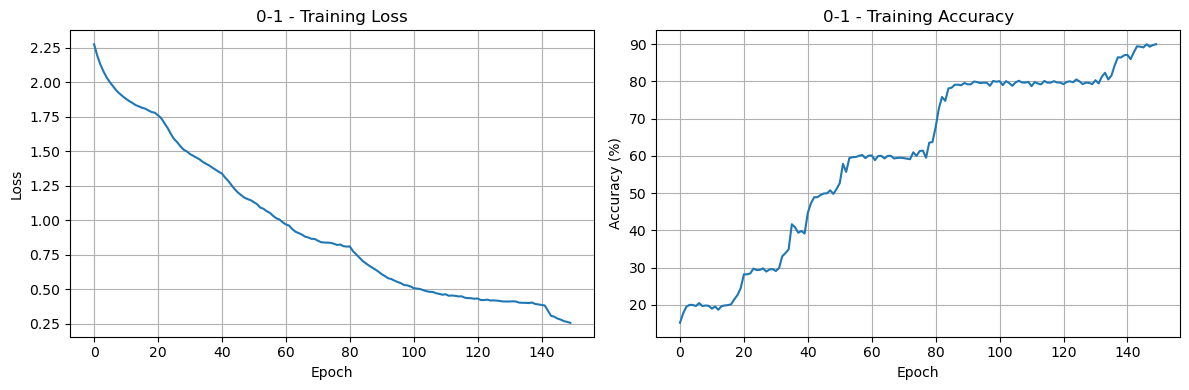

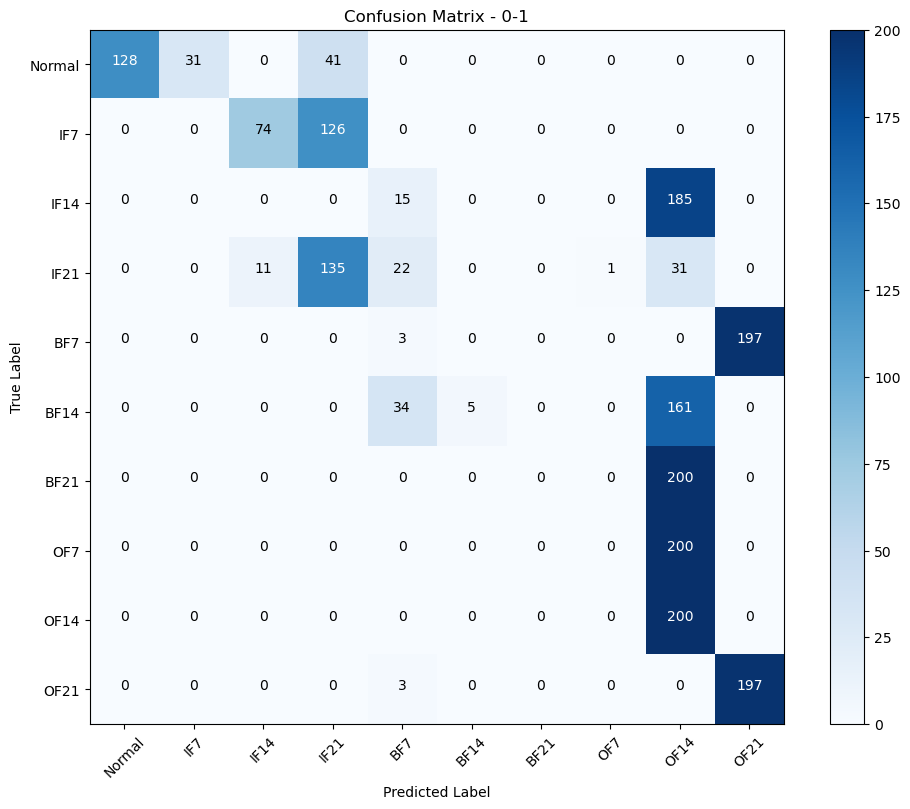


Training transfer task: 0 -> 2
Source domain 0: 2000 samples
Target domain 2: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 80.2722
Epoch [20/100], Loss: 68.6995
Epoch [30/100], Loss: 65.4707
Epoch [40/100], Loss: 57.2501
Epoch [50/100], Loss: 54.3482
Epoch [60/100], Loss: 50.3702
Epoch [70/100], Loss: 49.1954
Epoch [80/100], Loss: 41.1243
Epoch [90/100], Loss: 39.7966
Epoch [100/100], Loss: 33.6503
Training SAE layer 2...
Epoch [10/100], Loss: 18.0647
Epoch [20/100], Loss: 4.7233
Epoch [30/100], Loss: 1.0897
Epoch [40/100], Loss: 0.3065
Epoch [50/100], Loss: 0.2210
Epoch [60/100], Loss: 0.2125
Epoch [70/100], Loss: 0.2006
Epoch [80/100], Loss: 0.1864
Epoch [90/100], Loss: 0.1647
Epoch [100/100], Loss: 0.1491
Training SAE layer 3...
Epoch [10/100], Loss: 0.4455
Epoch [20/100], Loss: 0.0579
Epoch [30/100], Loss: 0.0458
Epoch [40/100], Loss: 0.0399
Epoch [50/100], Loss: 0.0397
Epoch [60/100], Loss: 0.0395
Epoch [70/100], Loss: 0.0392
Epoch [80/100

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


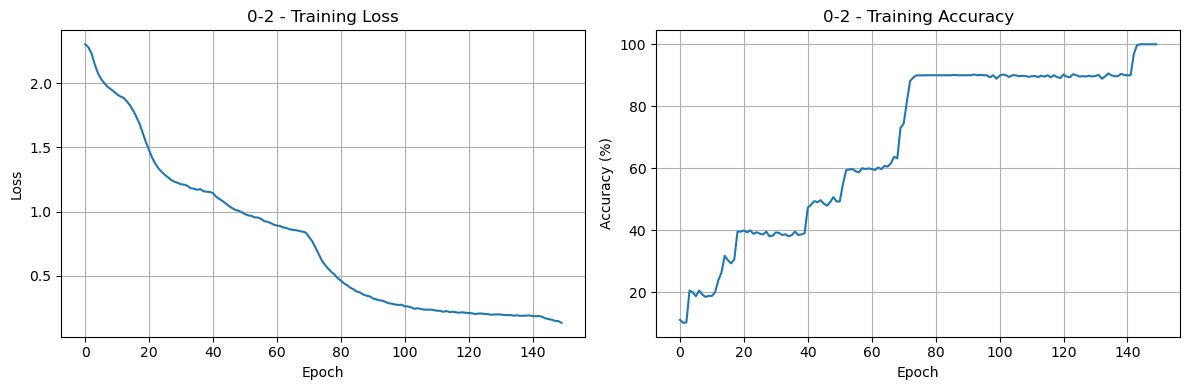

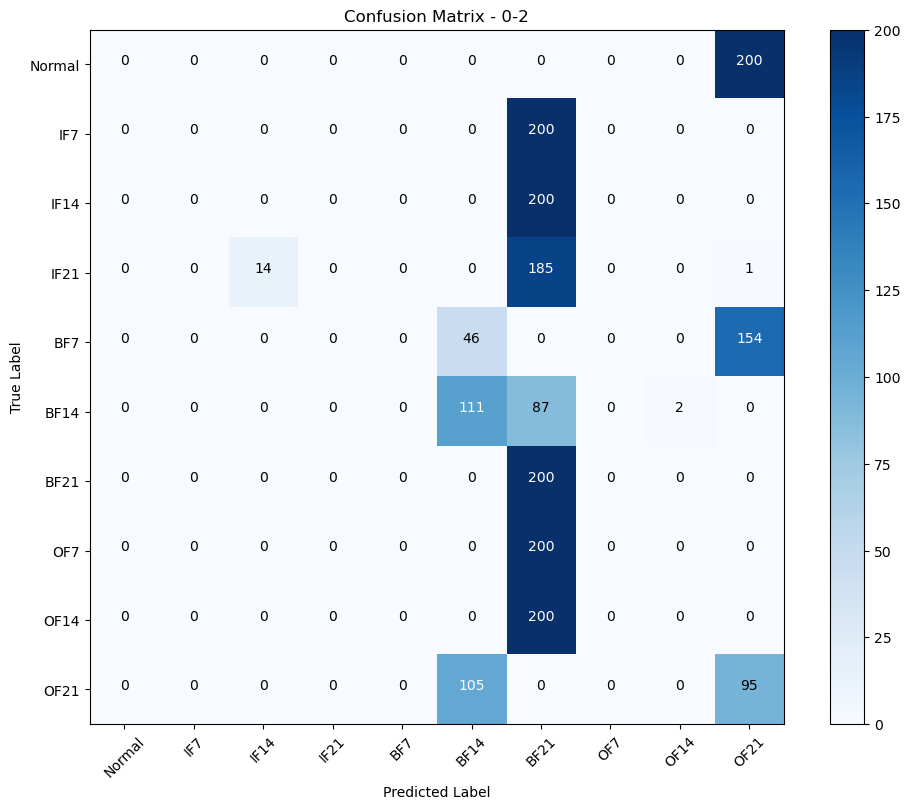


Training transfer task: 0 -> 3
Source domain 0: 2000 samples
Target domain 3: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 95.0623
Epoch [20/100], Loss: 38.7394
Epoch [30/100], Loss: 35.5972
Epoch [40/100], Loss: 32.3363
Epoch [50/100], Loss: 30.7641
Epoch [60/100], Loss: 28.6699
Epoch [70/100], Loss: 31.0764
Epoch [80/100], Loss: 30.0438
Epoch [90/100], Loss: 25.7813
Epoch [100/100], Loss: 29.4293
Training SAE layer 2...
Epoch [10/100], Loss: 5.1854
Epoch [20/100], Loss: 0.9394
Epoch [30/100], Loss: 0.3754
Epoch [40/100], Loss: 0.3466
Epoch [50/100], Loss: 0.3245
Epoch [60/100], Loss: 0.3513
Epoch [70/100], Loss: 0.2671
Epoch [80/100], Loss: 0.2737
Epoch [90/100], Loss: 0.2171
Epoch [100/100], Loss: 0.2082
Training SAE layer 3...
Epoch [10/100], Loss: 1.0936
Epoch [20/100], Loss: 0.2394
Epoch [30/100], Loss: 0.1045
Epoch [40/100], Loss: 0.0802
Epoch [50/100], Loss: 0.0708
Epoch [60/100], Loss: 0.0686
Epoch [70/100], Loss: 0.0650
Epoch [80/100]

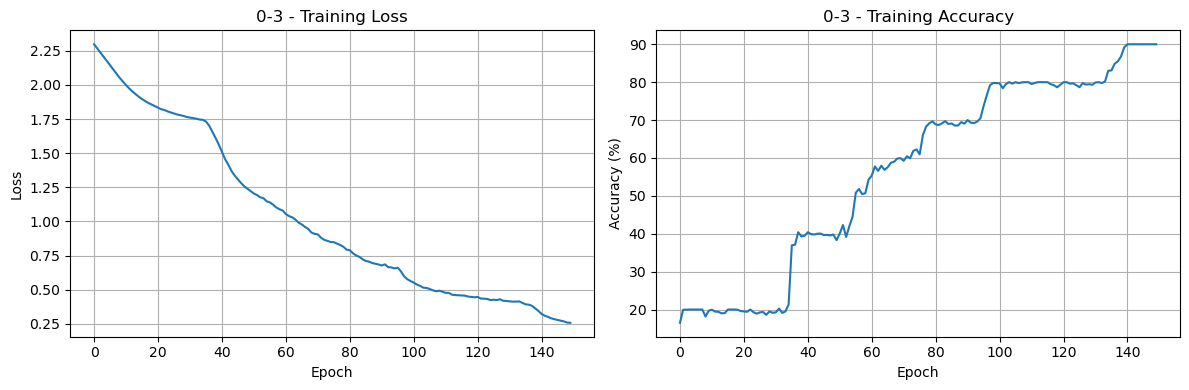

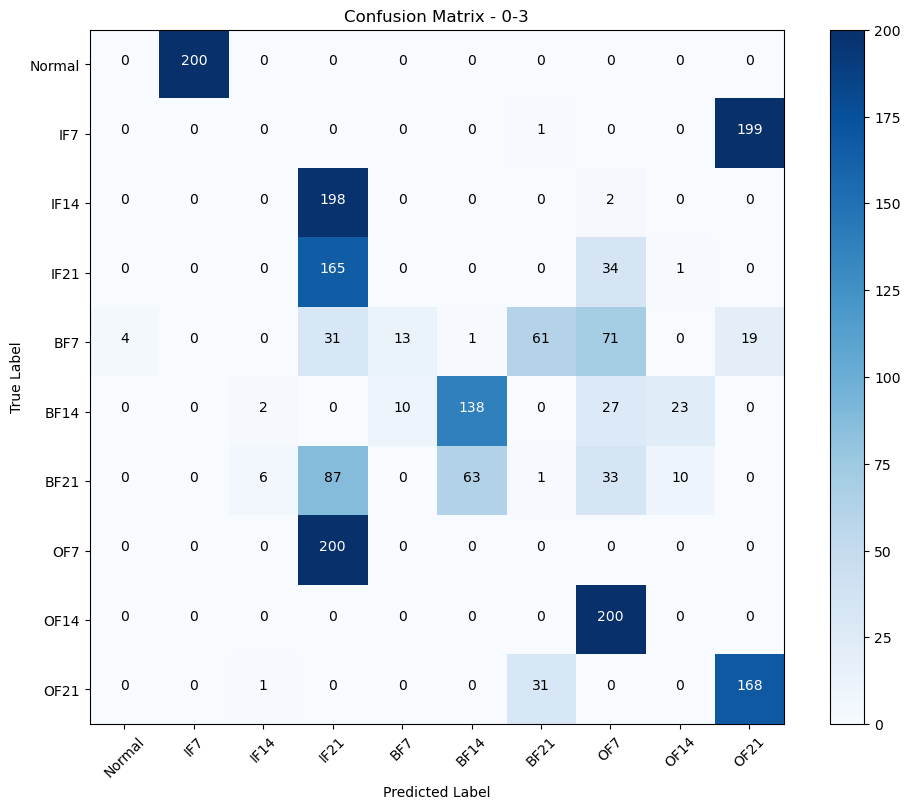


Training transfer task: 1 -> 0
Source domain 1: 2000 samples
Target domain 0: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 82.3601
Epoch [20/100], Loss: 70.9986
Epoch [30/100], Loss: 71.3276
Epoch [40/100], Loss: 76.6747
Epoch [50/100], Loss: 62.9616
Epoch [60/100], Loss: 49.2030
Epoch [70/100], Loss: 47.4038
Epoch [80/100], Loss: 47.2158
Epoch [90/100], Loss: 49.7238
Epoch [100/100], Loss: 53.7295
Training SAE layer 2...
Epoch [10/100], Loss: 13.1567
Epoch [20/100], Loss: 3.1915
Epoch [30/100], Loss: 0.7054
Epoch [40/100], Loss: 0.2779
Epoch [50/100], Loss: 0.2443
Epoch [60/100], Loss: 0.2519
Epoch [70/100], Loss: 0.2389
Epoch [80/100], Loss: 0.2247
Epoch [90/100], Loss: 0.1873
Epoch [100/100], Loss: 0.1754
Training SAE layer 3...
Epoch [10/100], Loss: 0.5230
Epoch [20/100], Loss: 0.0782
Epoch [30/100], Loss: 0.0593
Epoch [40/100], Loss: 0.0522
Epoch [50/100], Loss: 0.0519
Epoch [60/100], Loss: 0.0490
Epoch [70/100], Loss: 0.0459
Epoch [80/100

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


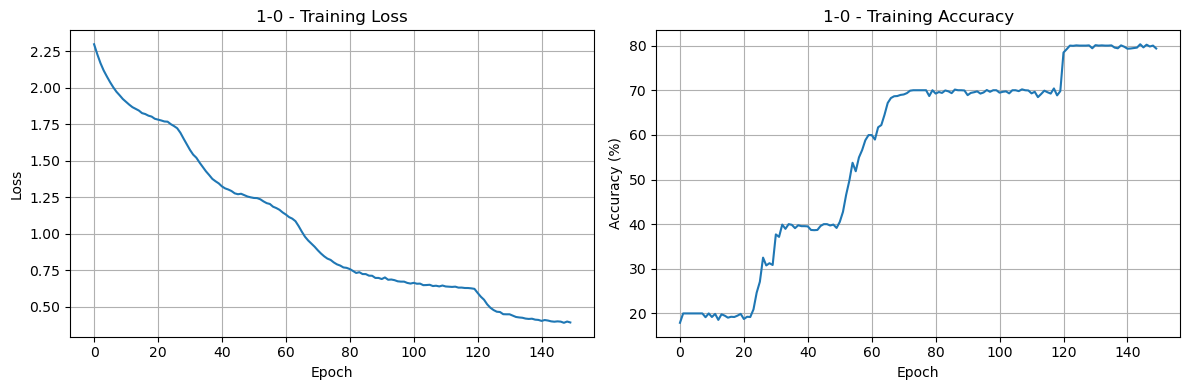

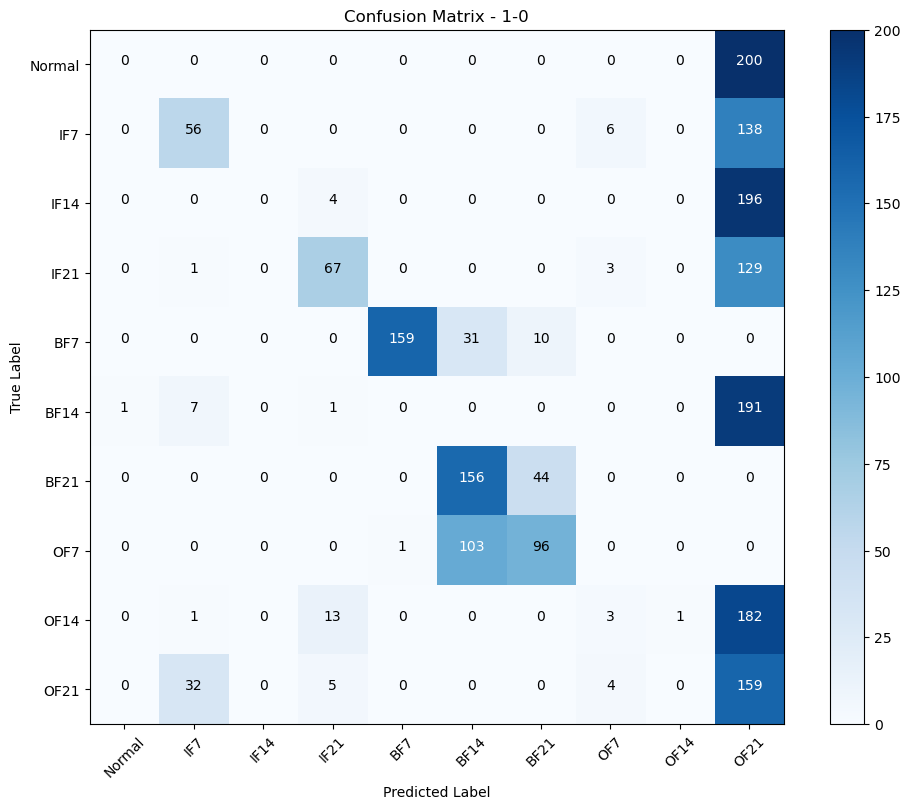


Training transfer task: 1 -> 2
Source domain 1: 2000 samples
Target domain 2: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 85.9545
Epoch [20/100], Loss: 88.1661
Epoch [30/100], Loss: 85.2002
Epoch [40/100], Loss: 86.0075
Epoch [50/100], Loss: 87.1259
Epoch [60/100], Loss: 86.8193
Epoch [70/100], Loss: 87.5096
Epoch [80/100], Loss: 88.5403
Epoch [90/100], Loss: 87.1784
Epoch [100/100], Loss: 92.6241
Training SAE layer 2...
Epoch [10/100], Loss: 17.4515
Epoch [20/100], Loss: 4.6759
Epoch [30/100], Loss: 1.0641
Epoch [40/100], Loss: 0.2736
Epoch [50/100], Loss: 0.1889
Epoch [60/100], Loss: 0.1880
Epoch [70/100], Loss: 0.1846
Epoch [80/100], Loss: 0.1902
Epoch [90/100], Loss: 0.1861
Epoch [100/100], Loss: 0.1887
Training SAE layer 3...
Epoch [10/100], Loss: 0.8312
Epoch [20/100], Loss: 0.1757
Epoch [30/100], Loss: 0.1002
Epoch [40/100], Loss: 0.0891
Epoch [50/100], Loss: 0.0726
Epoch [60/100], Loss: 0.0681
Epoch [70/100], Loss: 0.0549
Epoch [80/100

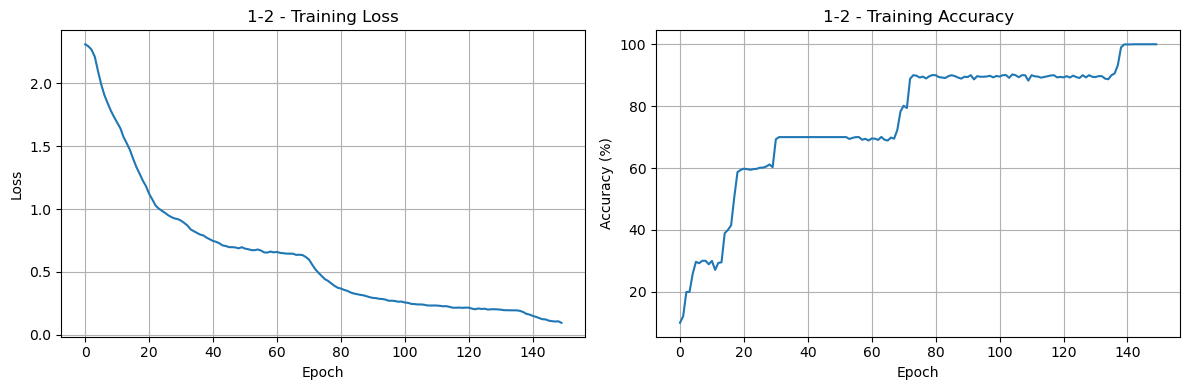

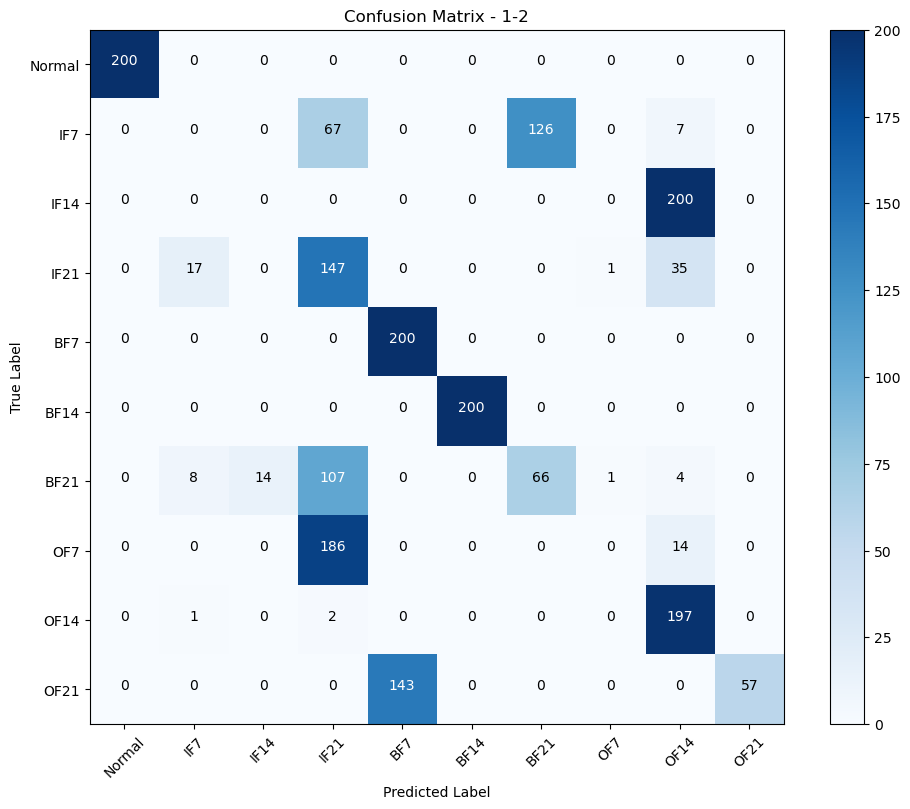


Training transfer task: 1 -> 3
Source domain 1: 2000 samples
Target domain 3: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 87.1463
Epoch [20/100], Loss: 86.9930
Epoch [30/100], Loss: 86.5278
Epoch [40/100], Loss: 90.2539
Epoch [50/100], Loss: 89.2968
Epoch [60/100], Loss: 78.6233
Epoch [70/100], Loss: 74.2736
Epoch [80/100], Loss: 69.3931
Epoch [90/100], Loss: 74.0463
Epoch [100/100], Loss: 72.0001
Training SAE layer 2...
Epoch [10/100], Loss: 14.3722
Epoch [20/100], Loss: 3.6764
Epoch [30/100], Loss: 0.8549
Epoch [40/100], Loss: 0.2939
Epoch [50/100], Loss: 0.2432
Epoch [60/100], Loss: 0.2409
Epoch [70/100], Loss: 0.2400
Epoch [80/100], Loss: 0.2174
Epoch [90/100], Loss: 0.1938
Epoch [100/100], Loss: 0.1786
Training SAE layer 3...
Epoch [10/100], Loss: 0.7532
Epoch [20/100], Loss: 0.1592
Epoch [30/100], Loss: 0.0942
Epoch [40/100], Loss: 0.0904
Epoch [50/100], Loss: 0.0736
Epoch [60/100], Loss: 0.0673
Epoch [70/100], Loss: 0.0572
Epoch [80/100

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


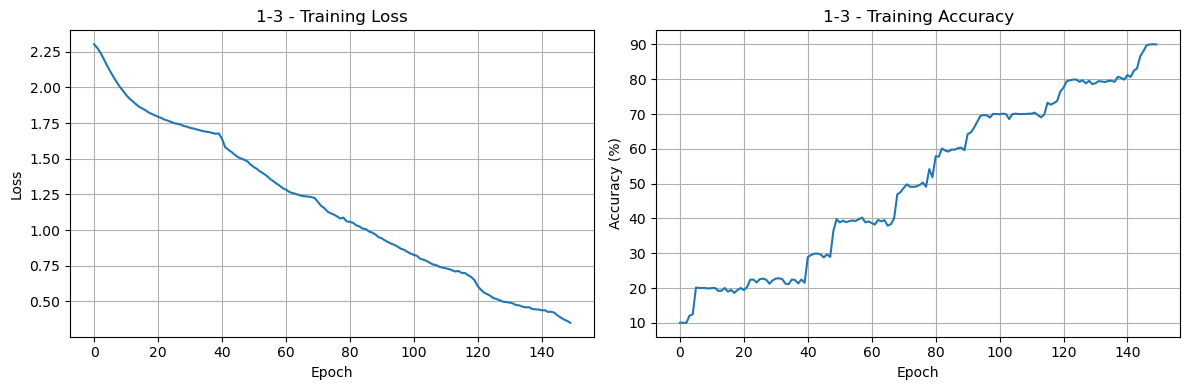

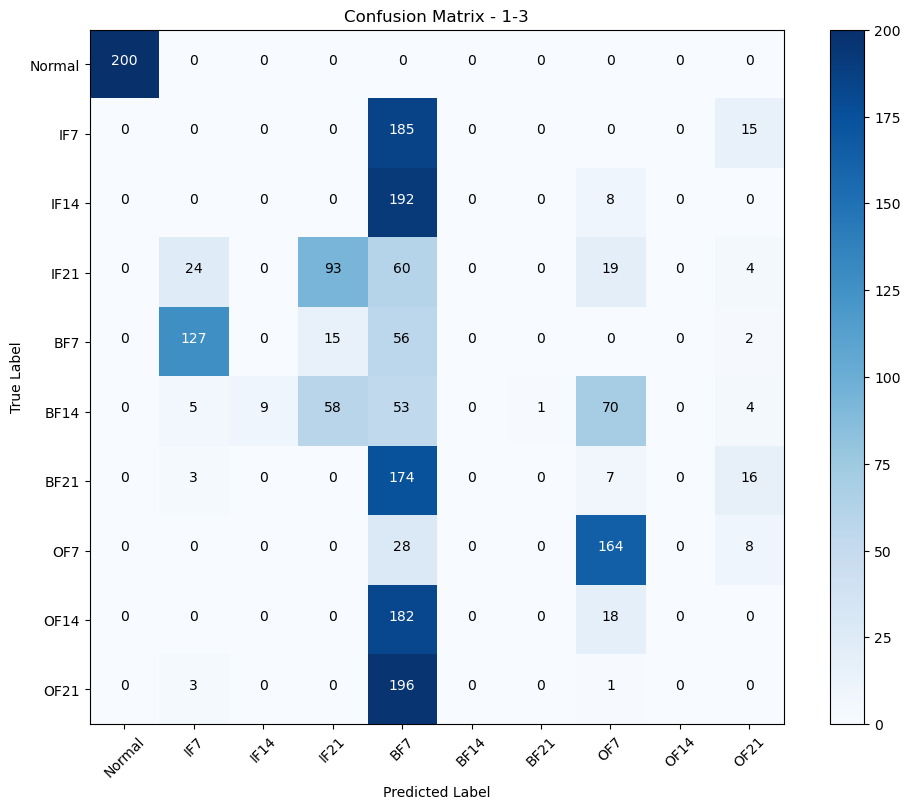


Training transfer task: 2 -> 0
Source domain 2: 2000 samples
Target domain 0: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 75.2160
Epoch [20/100], Loss: 70.7665
Epoch [30/100], Loss: 68.0049
Epoch [40/100], Loss: 70.1290
Epoch [50/100], Loss: 61.3194
Epoch [60/100], Loss: 61.6420
Epoch [70/100], Loss: 63.0133
Epoch [80/100], Loss: 61.9884
Epoch [90/100], Loss: 48.8914
Epoch [100/100], Loss: 42.8075
Training SAE layer 2...
Epoch [10/100], Loss: 14.3385
Epoch [20/100], Loss: 3.5391
Epoch [30/100], Loss: 0.8116
Epoch [40/100], Loss: 0.2926
Epoch [50/100], Loss: 0.2509
Epoch [60/100], Loss: 0.2510
Epoch [70/100], Loss: 0.2347
Epoch [80/100], Loss: 0.2174
Epoch [90/100], Loss: 0.1850
Epoch [100/100], Loss: 0.1626
Training SAE layer 3...
Epoch [10/100], Loss: 0.5964
Epoch [20/100], Loss: 0.0980
Epoch [30/100], Loss: 0.0682
Epoch [40/100], Loss: 0.0636
Epoch [50/100], Loss: 0.0595
Epoch [60/100], Loss: 0.0604
Epoch [70/100], Loss: 0.0552
Epoch [80/100

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


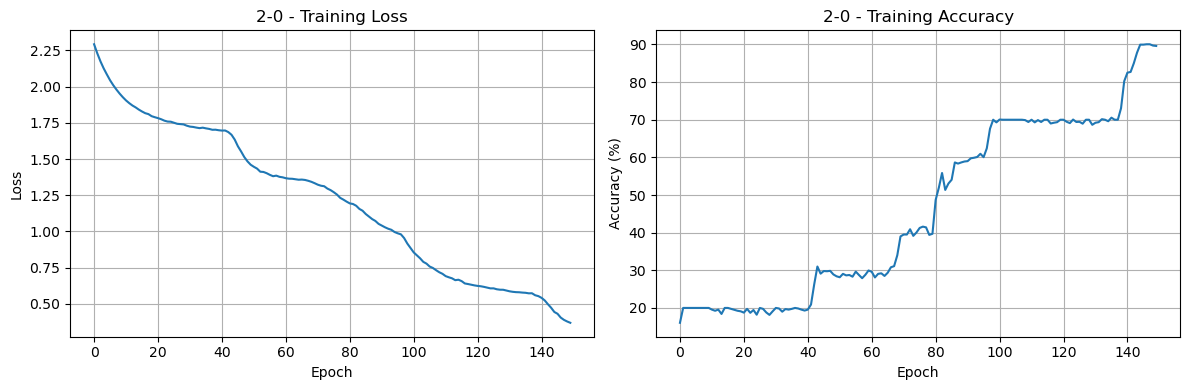

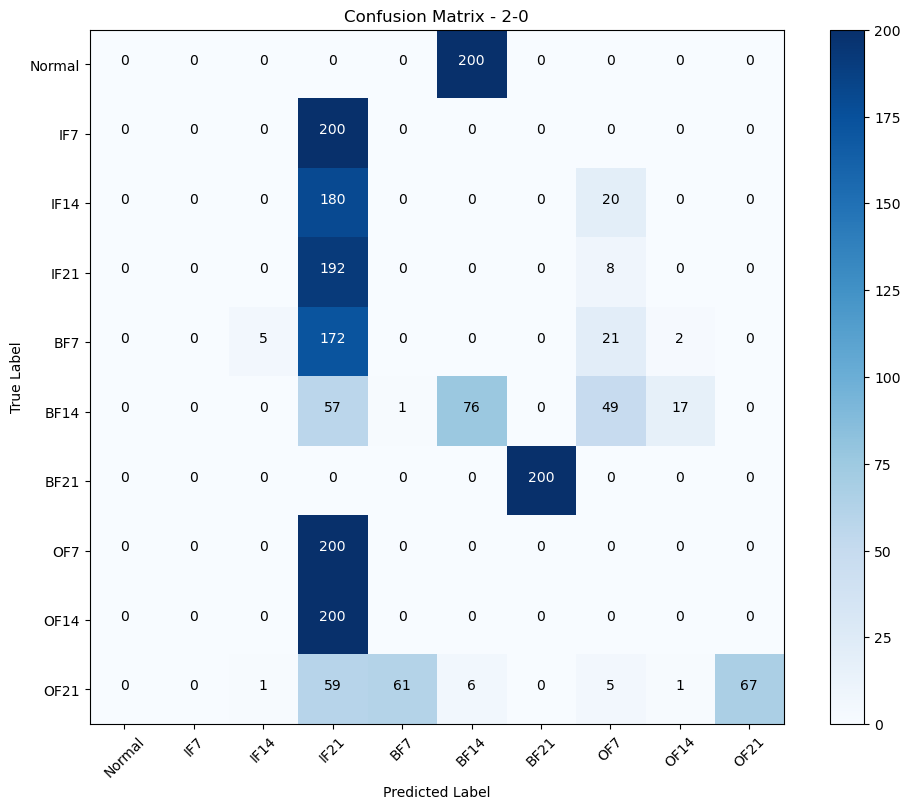


Training transfer task: 2 -> 1
Source domain 2: 2000 samples
Target domain 1: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 91.9172
Epoch [20/100], Loss: 87.9715
Epoch [30/100], Loss: 87.1112
Epoch [40/100], Loss: 93.3065
Epoch [50/100], Loss: 86.1502
Epoch [60/100], Loss: 93.6878
Epoch [70/100], Loss: 89.8825
Epoch [80/100], Loss: 89.6798
Epoch [90/100], Loss: 87.6445
Epoch [100/100], Loss: 87.3883
Training SAE layer 2...
Epoch [10/100], Loss: 17.4494
Epoch [20/100], Loss: 4.6785
Epoch [30/100], Loss: 1.0609
Epoch [40/100], Loss: 0.2769
Epoch [50/100], Loss: 0.1950
Epoch [60/100], Loss: 0.1860
Epoch [70/100], Loss: 0.1869
Epoch [80/100], Loss: 0.1787
Epoch [90/100], Loss: 0.1854
Epoch [100/100], Loss: 0.1836
Training SAE layer 3...
Epoch [10/100], Loss: 0.9007
Epoch [20/100], Loss: 0.2110
Epoch [30/100], Loss: 0.1197
Epoch [40/100], Loss: 0.0867
Epoch [50/100], Loss: 0.0851
Epoch [60/100], Loss: 0.0719
Epoch [70/100], Loss: 0.0572
Epoch [80/100

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


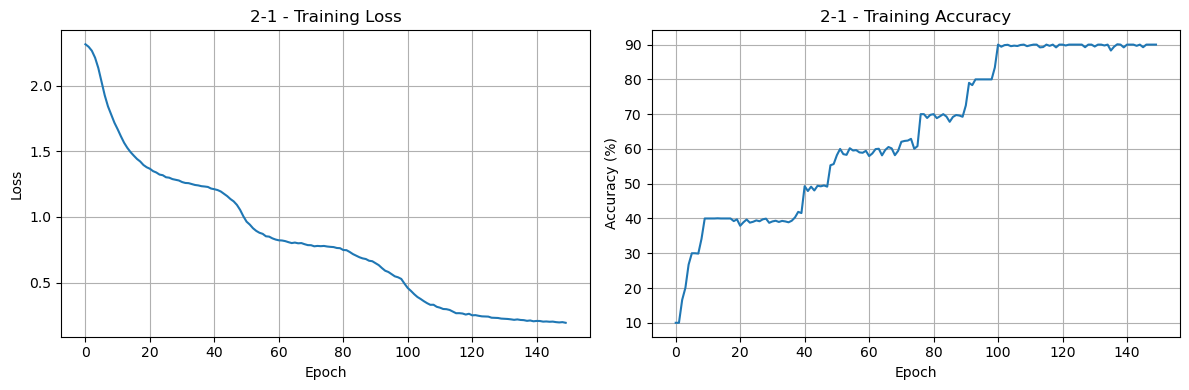

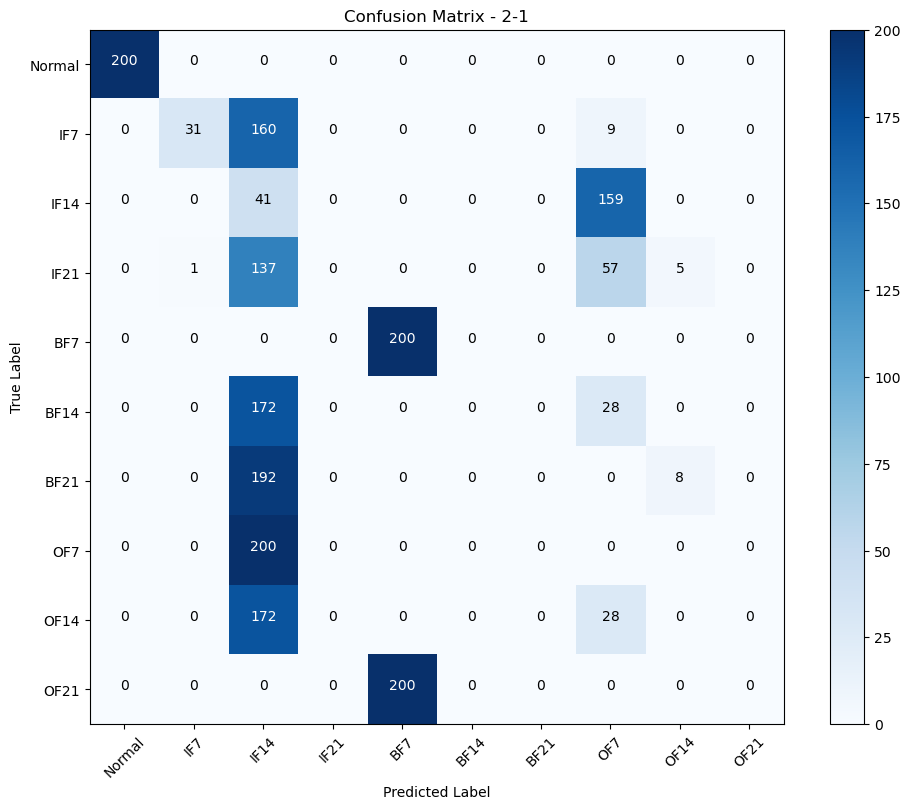


Training transfer task: 2 -> 3
Source domain 2: 2000 samples
Target domain 3: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 63.5246
Epoch [20/100], Loss: 59.5588
Epoch [30/100], Loss: 62.6784
Epoch [40/100], Loss: 56.6430
Epoch [50/100], Loss: 61.5061
Epoch [60/100], Loss: 57.5895
Epoch [70/100], Loss: 55.8364
Epoch [80/100], Loss: 62.8768
Epoch [90/100], Loss: 55.8977
Epoch [100/100], Loss: 62.2890
Training SAE layer 2...
Epoch [10/100], Loss: 9.3135
Epoch [20/100], Loss: 1.9990
Epoch [30/100], Loss: 0.5146
Epoch [40/100], Loss: 0.3209
Epoch [50/100], Loss: 0.3099
Epoch [60/100], Loss: 0.2935
Epoch [70/100], Loss: 0.2821
Epoch [80/100], Loss: 0.2683
Epoch [90/100], Loss: 0.2323
Epoch [100/100], Loss: 0.2010
Training SAE layer 3...
Epoch [10/100], Loss: 0.8719
Epoch [20/100], Loss: 0.1807
Epoch [30/100], Loss: 0.1068
Epoch [40/100], Loss: 0.0934
Epoch [50/100], Loss: 0.0867
Epoch [60/100], Loss: 0.0697
Epoch [70/100], Loss: 0.0582
Epoch [80/100]

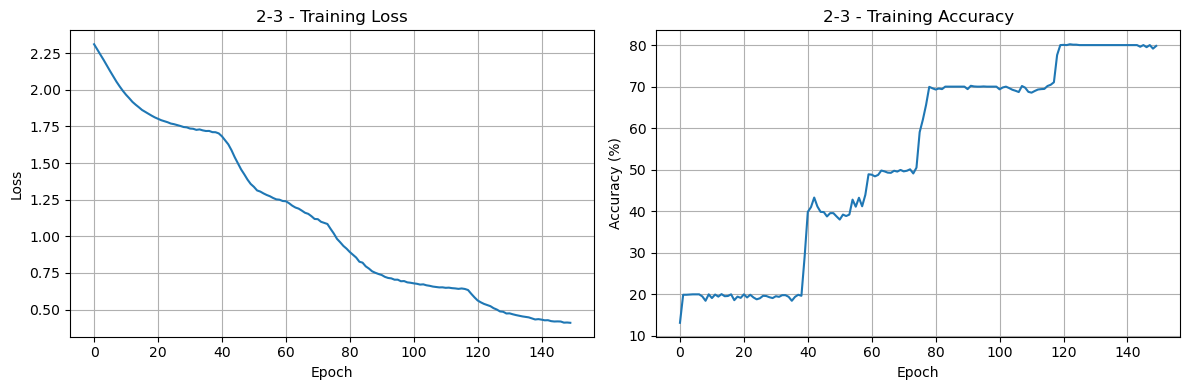

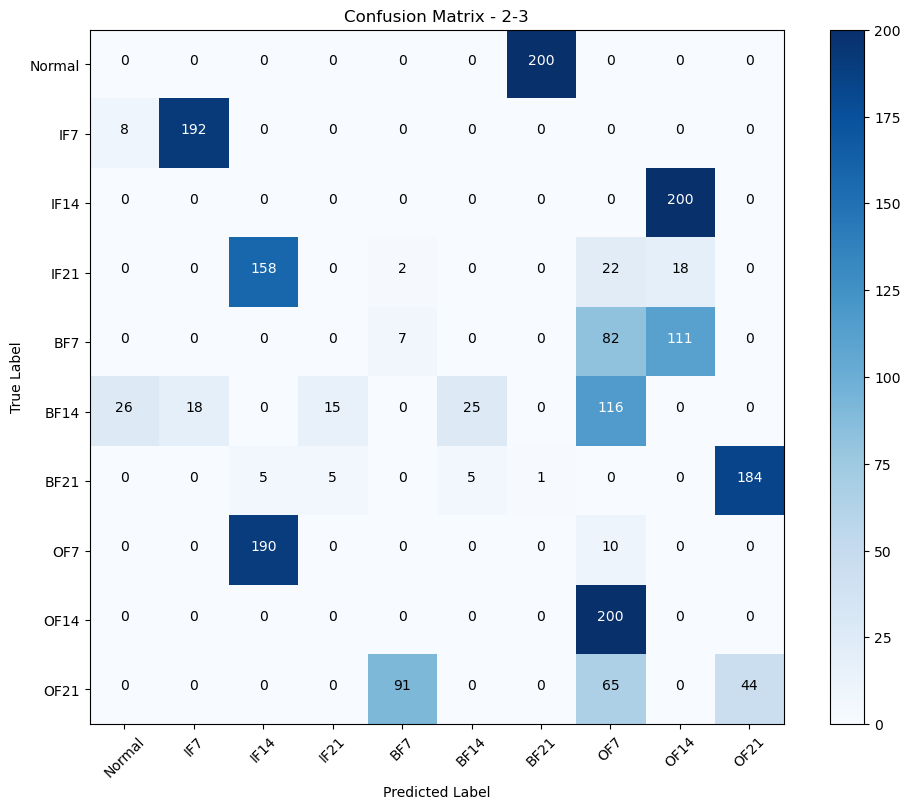


Training transfer task: 3 -> 0
Source domain 3: 2000 samples
Target domain 0: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 102.6484
Epoch [20/100], Loss: 44.7892
Epoch [30/100], Loss: 43.6367
Epoch [40/100], Loss: 39.4342
Epoch [50/100], Loss: 32.1561
Epoch [60/100], Loss: 36.2367
Epoch [70/100], Loss: 42.6204
Epoch [80/100], Loss: 43.6678
Epoch [90/100], Loss: 39.8500
Epoch [100/100], Loss: 39.2436
Training SAE layer 2...
Epoch [10/100], Loss: 11.5580
Epoch [20/100], Loss: 2.5983
Epoch [30/100], Loss: 0.6066
Epoch [40/100], Loss: 0.2836
Epoch [50/100], Loss: 0.2604
Epoch [60/100], Loss: 0.2518
Epoch [70/100], Loss: 0.2344
Epoch [80/100], Loss: 0.2255
Epoch [90/100], Loss: 0.2213
Epoch [100/100], Loss: 0.1885
Training SAE layer 3...
Epoch [10/100], Loss: 0.9156
Epoch [20/100], Loss: 0.1917
Epoch [30/100], Loss: 0.0987
Epoch [40/100], Loss: 0.0853
Epoch [50/100], Loss: 0.0732
Epoch [60/100], Loss: 0.0678
Epoch [70/100], Loss: 0.0616
Epoch [80/10

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


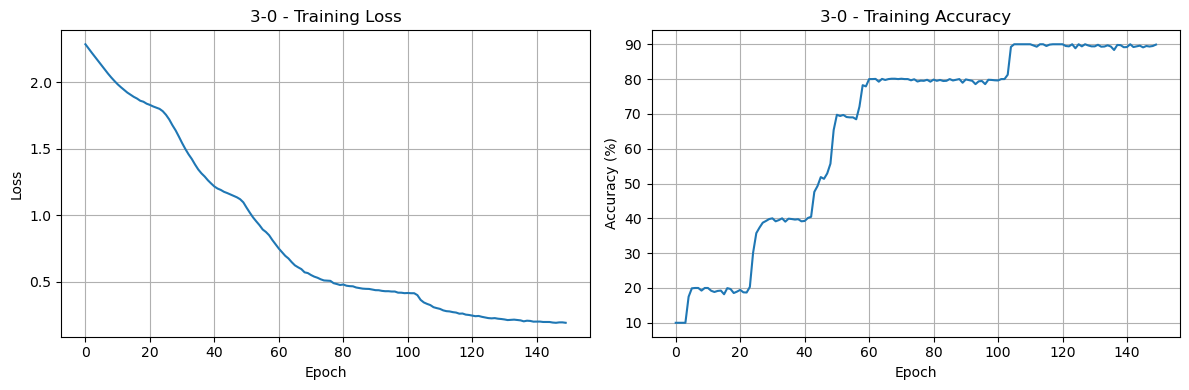

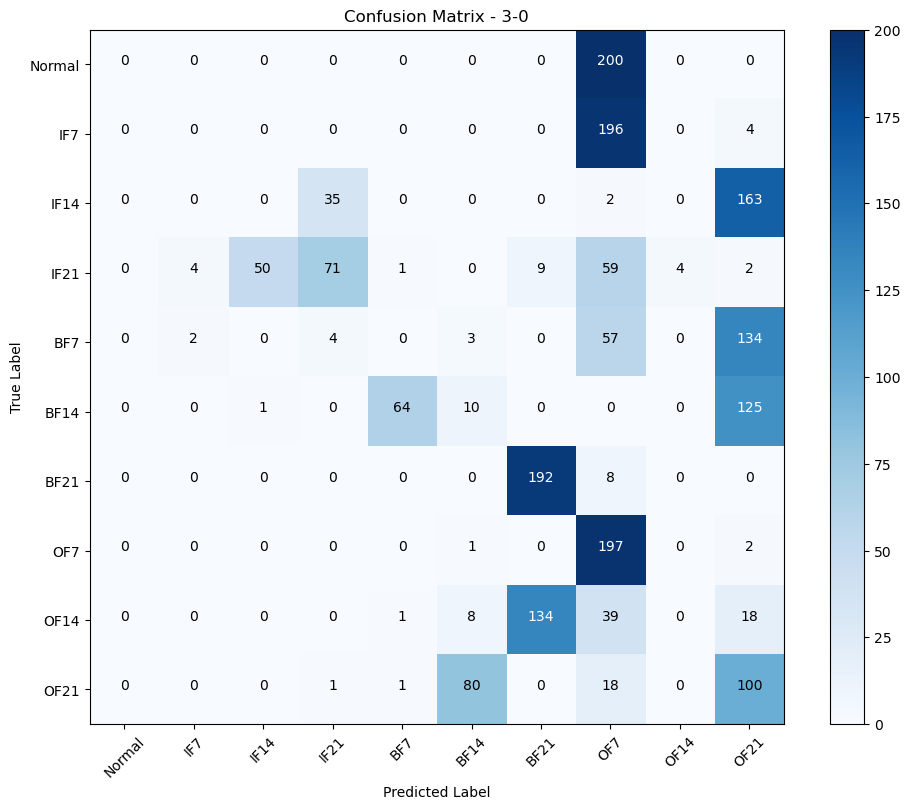


Training transfer task: 3 -> 1
Source domain 3: 2000 samples
Target domain 1: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 87.5209
Epoch [20/100], Loss: 90.5058
Epoch [30/100], Loss: 94.9081
Epoch [40/100], Loss: 86.2649
Epoch [50/100], Loss: 85.3312
Epoch [60/100], Loss: 88.2769
Epoch [70/100], Loss: 84.8329
Epoch [80/100], Loss: 82.2510
Epoch [90/100], Loss: 78.4293
Epoch [100/100], Loss: 74.8495
Training SAE layer 2...
Epoch [10/100], Loss: 15.1431
Epoch [20/100], Loss: 3.8974
Epoch [30/100], Loss: 0.8918
Epoch [40/100], Loss: 0.2906
Epoch [50/100], Loss: 0.2362
Epoch [60/100], Loss: 0.2279
Epoch [70/100], Loss: 0.2208
Epoch [80/100], Loss: 0.2129
Epoch [90/100], Loss: 0.1965
Epoch [100/100], Loss: 0.1871
Training SAE layer 3...
Epoch [10/100], Loss: 0.8082
Epoch [20/100], Loss: 0.1784
Epoch [30/100], Loss: 0.1115
Epoch [40/100], Loss: 0.0865
Epoch [50/100], Loss: 0.0782
Epoch [60/100], Loss: 0.0658
Epoch [70/100], Loss: 0.0572
Epoch [80/100

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


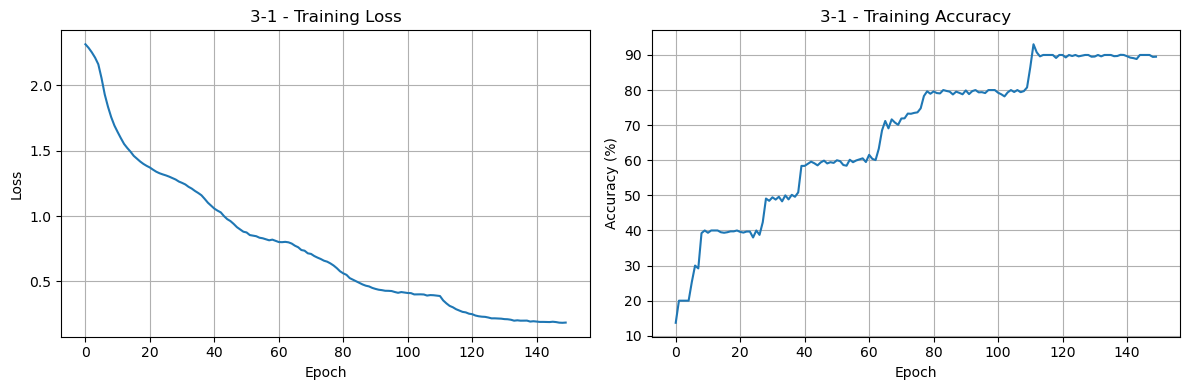

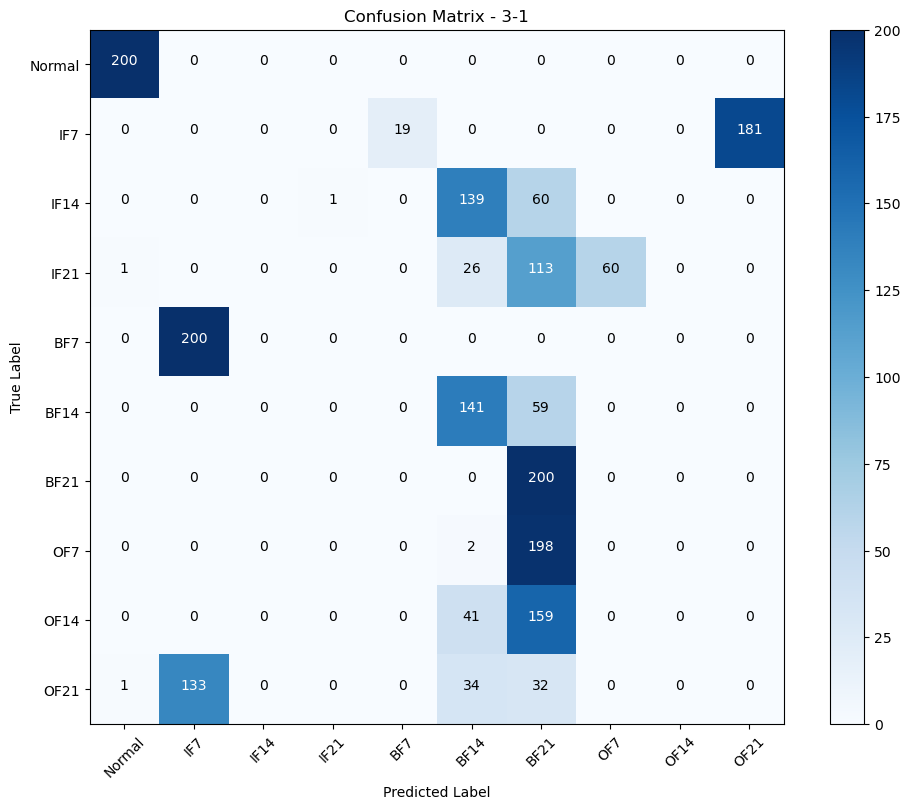


Training transfer task: 3 -> 2
Source domain 3: 2000 samples
Target domain 2: 2000 samples
Pre-training SAE layers...
Training SAE layer 1...
Epoch [10/100], Loss: 58.6047
Epoch [20/100], Loss: 50.4470
Epoch [30/100], Loss: 46.4195
Epoch [40/100], Loss: 60.9848
Epoch [50/100], Loss: 52.5624
Epoch [60/100], Loss: 44.9703
Epoch [70/100], Loss: 46.9906
Epoch [80/100], Loss: 45.6185
Epoch [90/100], Loss: 45.8625
Epoch [100/100], Loss: 52.5113
Training SAE layer 2...
Epoch [10/100], Loss: 14.5273
Epoch [20/100], Loss: 3.7298
Epoch [30/100], Loss: 0.8533
Epoch [40/100], Loss: 0.2919
Epoch [50/100], Loss: 0.2405
Epoch [60/100], Loss: 0.2368
Epoch [70/100], Loss: 0.2290
Epoch [80/100], Loss: 0.2124
Epoch [90/100], Loss: 0.1995
Epoch [100/100], Loss: 0.1786
Training SAE layer 3...
Epoch [10/100], Loss: 0.6740
Epoch [20/100], Loss: 0.1328
Epoch [30/100], Loss: 0.0900
Epoch [40/100], Loss: 0.0709
Epoch [50/100], Loss: 0.0684
Epoch [60/100], Loss: 0.0667
Epoch [70/100], Loss: 0.0552
Epoch [80/100

D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
D:\anaconda3\envs\EWSnet\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


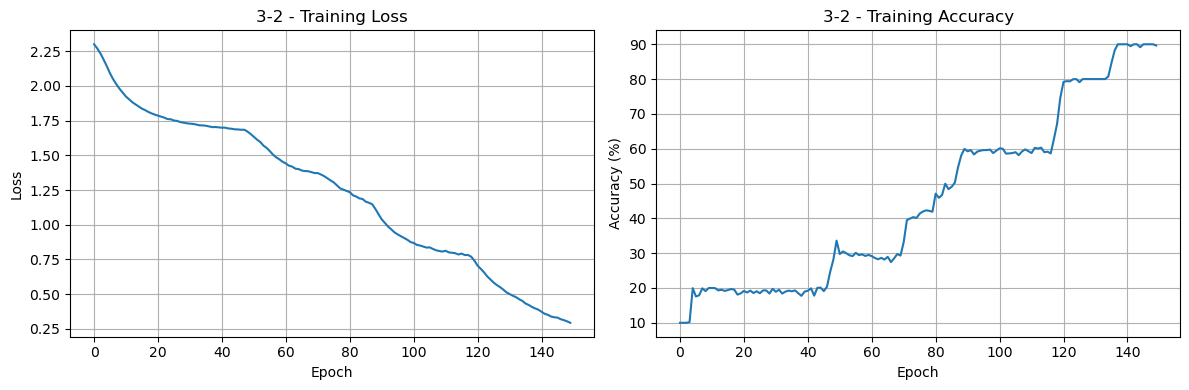

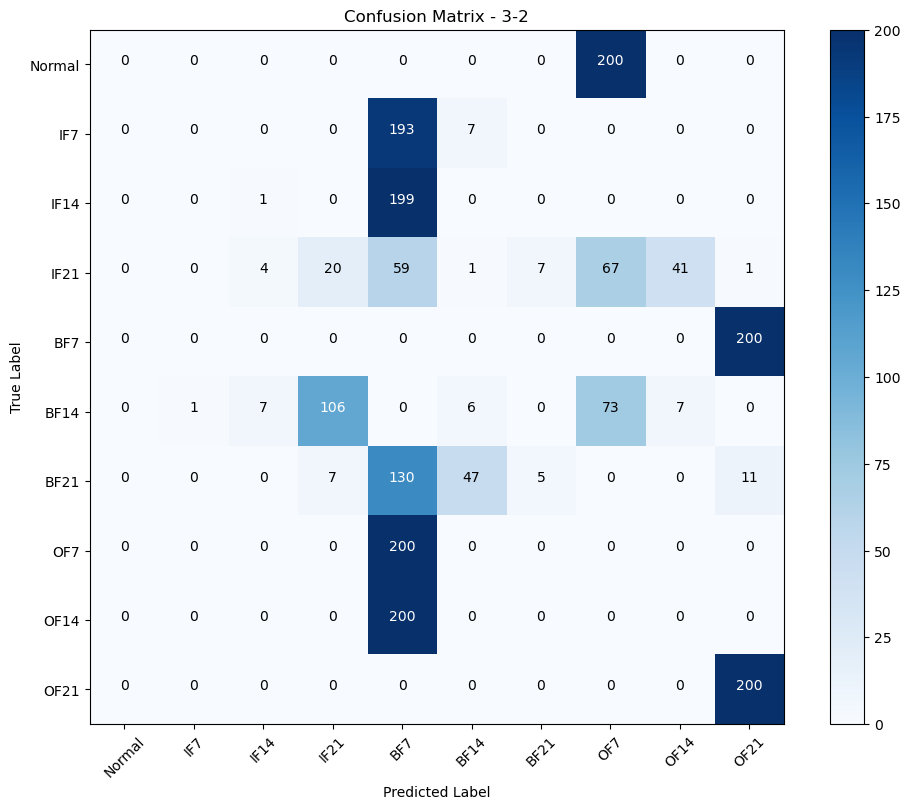


FINAL TRANSFER LEARNING RESULTS
0-1: 0.3340
0-2: 0.2030
0-3: 0.2425
1-0: 0.2430
1-2: 0.5335
1-3: 0.2565
2-0: 0.2675
2-1: 0.2360
2-3: 0.1395
3-0: 0.2850
3-1: 0.2705
3-2: 0.1160

Best transfer task: 1-2 (Accuracy: 0.5335)
Worst transfer task: 3-2 (Accuracy: 0.1160)
Best model saved from task: 1-2


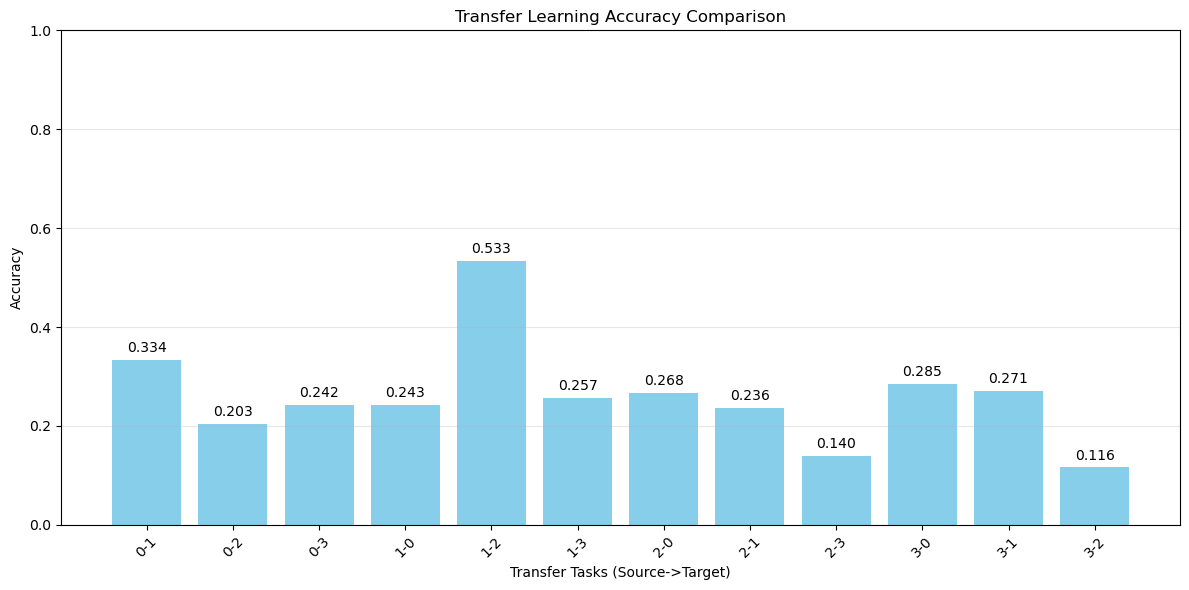

In [40]:
def create_class_names():
    """创建类别名称"""
    class_names = ['Normal']
    fault_types = ['IF', 'BF', 'OF']
    fault_sizes = ['7', '14', '21']

    for fault_type in fault_types:
        for size in fault_sizes:
            class_names.append(f'{fault_type}{size}')

    return class_names

# 主执行流程
def main():
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # 加载数据
    print("Loading bearing data...")
    data_path = r"D:\deskbook\科研\数据集\cwru\data"  # 修改为您的数据路径
    datasets = load_bearing_data(data_path)

    if not datasets:
        print("No data loaded! Please check your data path and file structure.")
        return

    # 数据预处理
    print("Preprocessing data...")
    processed_datasets = preprocess_data(datasets)

    # 定义迁移任务 (源域-目标域)
    transfer_tasks = [
        ('0', '1'), ('0', '2'), ('0', '3'),
        ('1', '0'), ('1', '2'), ('1', '3'),
        ('2', '0'), ('2', '1'), ('2', '3'),
        ('3', '0'), ('3', '1'), ('3', '2')
    ]

    results = {}
    class_names = create_class_names()

    for source_load, target_load in transfer_tasks:
        if source_load not in processed_datasets or target_load not in processed_datasets:
            print(f"Skipping {source_load}->{target_load}: data not available")
            continue

        print(f"\n{'='*50}")
        print(f"Training transfer task: {source_load} -> {target_load}")
        print(f"{'='*50}")

        source_data = processed_datasets[source_load]
        target_data = processed_datasets[target_load]

        print(f"Source domain {source_load}: {source_data['data'].shape[0]} samples")
        print(f"Target domain {target_load}: {target_data['data'].shape[0]} samples")

        # 训练DTL模型
        model, history = train_dtl_model(source_data, target_data, device=device)

        # 评估模型
        accuracy, cm, predictions, true_labels, probabilities = evaluate_model(model, target_data, device=device)

        results[f"{source_load}-{target_load}"] = {
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'history': history,
            'model': model,
            'predictions': predictions,
            'true_labels': true_labels
        }

        print(f"\nTransfer {source_load}->{target_load}: Accuracy = {accuracy:.4f}")

        # 输出分类报告
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions, target_names=class_names))

        # 绘制训练历史和混淆矩阵
        plot_training_history(history, f"{source_load}-{target_load}")
        plot_confusion_matrix(cm, class_names, f"{source_load}-{target_load}")

    # 输出最终结果
    print("\n" + "="*60)
    print("FINAL TRANSFER LEARNING RESULTS")
    print("="*60)

    for task, result in results.items():
        print(f"{task}: {result['accuracy']:.4f}")

    # 找出最佳模型
    if results:
        best_task = max(results, key=lambda x: results[x]['accuracy'])
        best_accuracy = results[best_task]['accuracy']
        worst_task = min(results, key=lambda x: results[x]['accuracy'])
        worst_accuracy = results[worst_task]['accuracy']

        print(f"\nBest transfer task: {best_task} (Accuracy: {best_accuracy:.4f})")
        print(f"Worst transfer task: {worst_task} (Accuracy: {worst_accuracy:.4f})")

        # 保存最佳模型
        best_model = results[best_task]['model']
        torch.save(best_model.state_dict(), 'best_dtl_model.pth')
        print(f"Best model saved from task: {best_task}")

        # 绘制所有任务的准确率比较
        tasks = list(results.keys())
        accuracies = [results[task]['accuracy'] for task in tasks]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(tasks, accuracies, color='skyblue')
        plt.title('Transfer Learning Accuracy Comparison')
        plt.xlabel('Transfer Tasks (Source->Target)')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        plt.ylim(0, 1.0)
        plt.grid(axis='y', alpha=0.3)

        # 在柱状图上显示数值
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{accuracy:.3f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('transfer_learning_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    main()

In [25]:
import scipy.io
import numpy as np
import os

def display_mat_info(file_path):
    """
    读取.mat文件并显示其内容信息

    参数:
        file_path (str): .mat文件路径
    """
    # 检查文件是否存在
    if not os.path.exists(file_path):
        print(f"错误: 文件 '{file_path}' 不存在")
        return

    try:
        # 读取.mat文件
        mat_data = scipy.io.loadmat(file_path)

        print(f"文件: {file_path}")
        print("=" * 50)

        # 显示文件中的变量
        print(f"文件中包含的变量: {list(mat_data.keys())}")
        print()

        # 遍历所有变量
        for key, value in mat_data.items():
            # 跳过以'__'开头的系统变量
            if key.startswith('__'):
                continue

            print(f"变量名: {key}")
            print(f"  类型: {type(value)}")
            print(f"  数据类型: {value.dtype if hasattr(value, 'dtype') else 'N/A'}")
            print(f"  形状: {value.shape if hasattr(value, 'shape') else 'N/A'}")

            # 如果是数组，显示更多信息
            if isinstance(value, np.ndarray):
                print(f"  数组维度: {value.ndim}")
                print(f"  总元素数: {value.size}")

                # 显示数组内容（如果元素不多）
                if value.size <= 10:
                    print(f"  内容: {value}")
                else:
                    print(f"  内容: [显示前5个元素] {value.flat[:5] if value.ndim > 1 else value[:5]}")

            print("-" * 30)

    except Exception as e:
        print(f"读取文件时出错: {e}")

# 示例使用
if __name__ == "__main__":
    # 替换为你的.mat文件路径
    file_path = r"D:\deskbook\科研\数据集\cwru\data\0\N.mat"

    # 如果文件不存在，创建一个示例文件
    if not os.path.exists(file_path):
        print(f"创建示例文件: {file_path}")
        # 创建示例数据
        sample_data = {
            'array_1d': np.array([1, 2, 3, 4, 5]),
            'array_2d': np.array([[1, 2, 3], [4, 5, 6]]),
            'scalar': 42,
            'string': 'Hello MATLAB',
            'matrix': np.random.rand(3, 4)
        }
        scipy.io.savemat(file_path, sample_data)

    # 显示.mat文件信息
    display_mat_info(file_path)

文件: D:\deskbook\科研\数据集\cwru\data\0\N.mat
文件中包含的变量: ['__header__', '__version__', '__globals__', 'X097_DE_time', 'X097_FE_time', 'X097RPM']

变量名: X097_DE_time
  类型: <class 'numpy.ndarray'>
  数据类型: float64
  形状: (243938, 1)
  数组维度: 2
  总元素数: 243938
  内容: [显示前5个元素] [ 0.05319692  0.08866154  0.09971815  0.05862092 -0.00458954]
------------------------------
变量名: X097_FE_time
  类型: <class 'numpy.ndarray'>
  数据类型: float64
  形状: (243938, 1)
  数组维度: 2
  总元素数: 243938
  内容: [显示前5个元素] [0.14566727 0.09779636 0.05485636 0.03698182 0.05444545]
------------------------------
变量名: X097RPM
  类型: <class 'numpy.ndarray'>
  数据类型: uint16
  形状: (1, 1)
  数组维度: 2
  总元素数: 1
  内容: [[1796]]
------------------------------
